#  Pipe2 : 
## Car Damaged or Not?

In [57]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
%matplotlib inline
sns.set_style('whitegrid')

In [118]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file

In [104]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [77]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [80]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [26]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [100]:
def train_top_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    nb_train_samples = train_data.shape[0]
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    train_labels=np.append(train_labels, 1)
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    nb_validation_samples = validation_data.shape[0]
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
    train_data = tf.stack(train_data)
    train_labels = tf.stack(train_labels)
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f) 
        
    return model, fit.history

In [121]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    #top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    optimizer = SGD(learning_rate=1e-4, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history        

In [108]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Defining input data

In [125]:
location = 'D:/Dataset/New/data3a'
top_model_weights_path = location+'/top_model_weights.weights.h5'
fine_tuned_model_path = location+'/ft_model.keras'

train_data_dir = location+'/t'
validation_data_dir = location+'/v'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

img_width, img_height = 256,256
epochs = 50
batch_size = 16

In [43]:
save_bottleneck_features()

Found 1383 images belonging to 3 classes.
87/87 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step
Found 248 images belonging to 3 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


In [102]:
d2_model1, d2_history1 = train_top_model()

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6048 - loss: 3.6209
Epoch 1: val_accuracy improved from -inf to 0.77419, saving model to D:/Dataset/New/data3a/top_model_weights.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6054 - loss: 3.6012 - val_accuracy: 0.7742 - val_loss: 0.4346
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6803 - loss: 0.7178
Epoch 2: val_accuracy did not improve from 0.77419
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6804 - loss: 0.7172 - val_accuracy: 0.6935 - val_loss: 0.6496
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7518 - loss: 0.6139
Epoch 3: val_accuracy improved from 0.77419 to 0.80242, saving model to D:/Dataset/New/data3a/top_model_weights.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7517 - loss: 0.6139 - val_accuracy: 0.8024 - val_loss: 0.3899
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7830 - loss: 0.4687
Epoch 4: val_accur

Best Model:
epoch: 47 , val_acc: 0.8346773982048035 , val_loss: 1.458953619003296


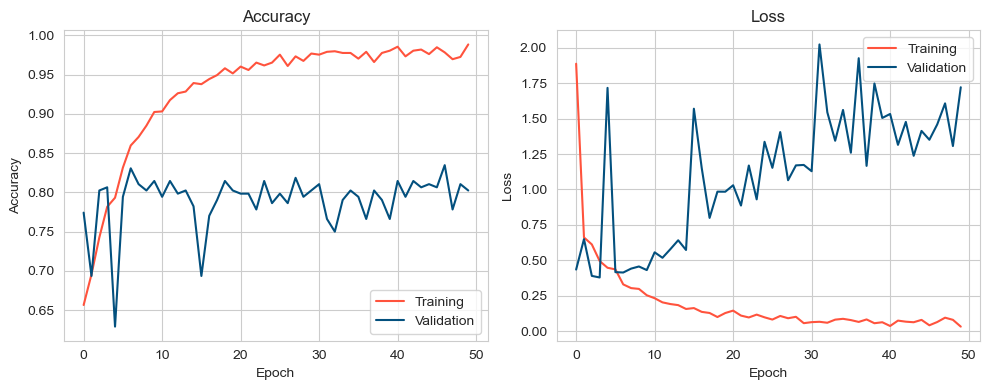

In [105]:
plot_metrics(d2_history1)

### Fine Tuning

In [126]:
ft_model, ft_history = finetune_binary_model()

Model loaded.
Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3152 - loss: 1.1013
Epoch 1: val_accuracy improved from -inf to 0.30417, saving model to D:/Dataset/New/data3a/ft_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.3152 - loss: 1.1018 - val_accuracy: 0.3042 - val_loss: 1.0620
Epoch 2/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.4375 - loss: 1.1085

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.30417
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4375 - loss: 0.5607 - val_accuracy: 0.1250 - val_loss: 0.5981
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3398 - loss: 1.1246
Epoch 3: val_accuracy did not improve from 0.30417
86/86 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.3396 - loss: 1.1248 - val_accuracy: 0.3000 - val_loss: 1.0686
Epoch 4/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.3125 - loss: 1.2598
Epoch 4: val_accuracy did not improve from 0.30417
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3125 - loss: 0.6372 - val_accuracy: 0.2500 - val_loss: 0.5002
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3174 - loss: 1.1873
Epoch 5: val_accuracy did not improve from 0.30417
86/86 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.3176 - loss: 1.1869 - val_accuracy: 0.2958 - val_loss: 1.0675
Epoch 6/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.2500 - loss: 1.

Best Model:
epoch: 16 , val_acc: 0.625 , val_loss: 0.47056037187576294


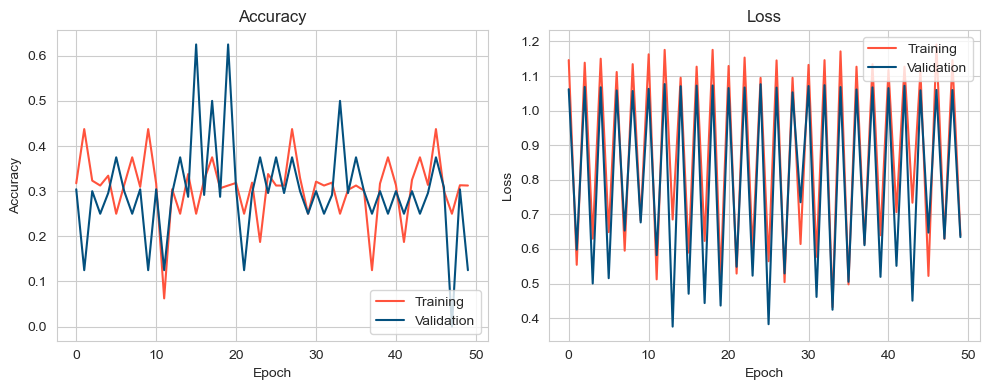

In [127]:
plot_metrics(ft_history)

### Load Model

In [129]:
ft_model = load_model(location+'/ft_model.keras')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 32 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [131]:
with open('D:/Dataset/New/data3a/top_history.txt') as f:    
    top_history = json.load(f)

In [132]:
with open('D:/Dataset/New/data3a/ft_history.txt') as f:    
    ft_history = json.load(f)

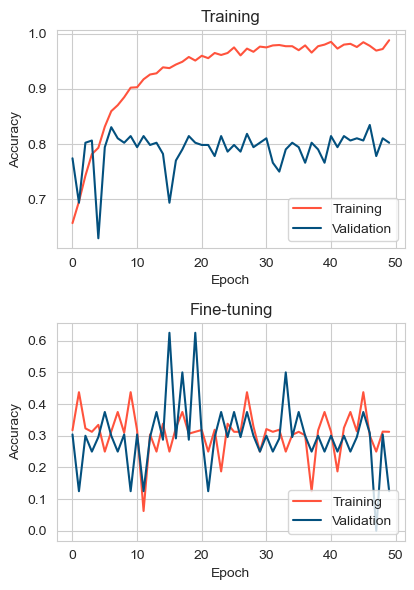

In [133]:
plot_acc_metrics(top_history, ft_history)

In [134]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [135]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 248 images belonging to 3 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step

              precision    recall  f1-score   support

           0       0.49      0.90      0.63       124
           1       0.37      0.06      0.10       124

    accuracy                           0.48       248
   macro avg       0.43      0.48      0.37       248
weighted avg       0.43      0.48      0.37       248




In [138]:
heatmap_labels = ['Damaged', 'Whole']

<Axes: >

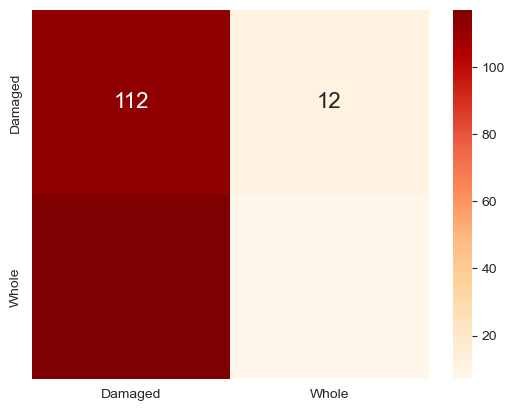

In [139]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

<Axes: >

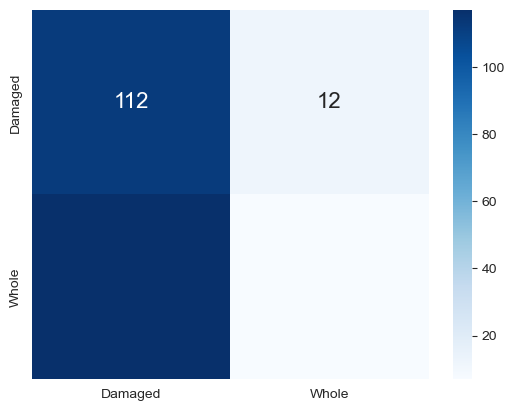

In [141]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

## Pipe2

In [142]:
def pipe2(image_path, model):
    #urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img(r'C:\Users\chara\OneDrive\Desktop\ford.jpeg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        print("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")      

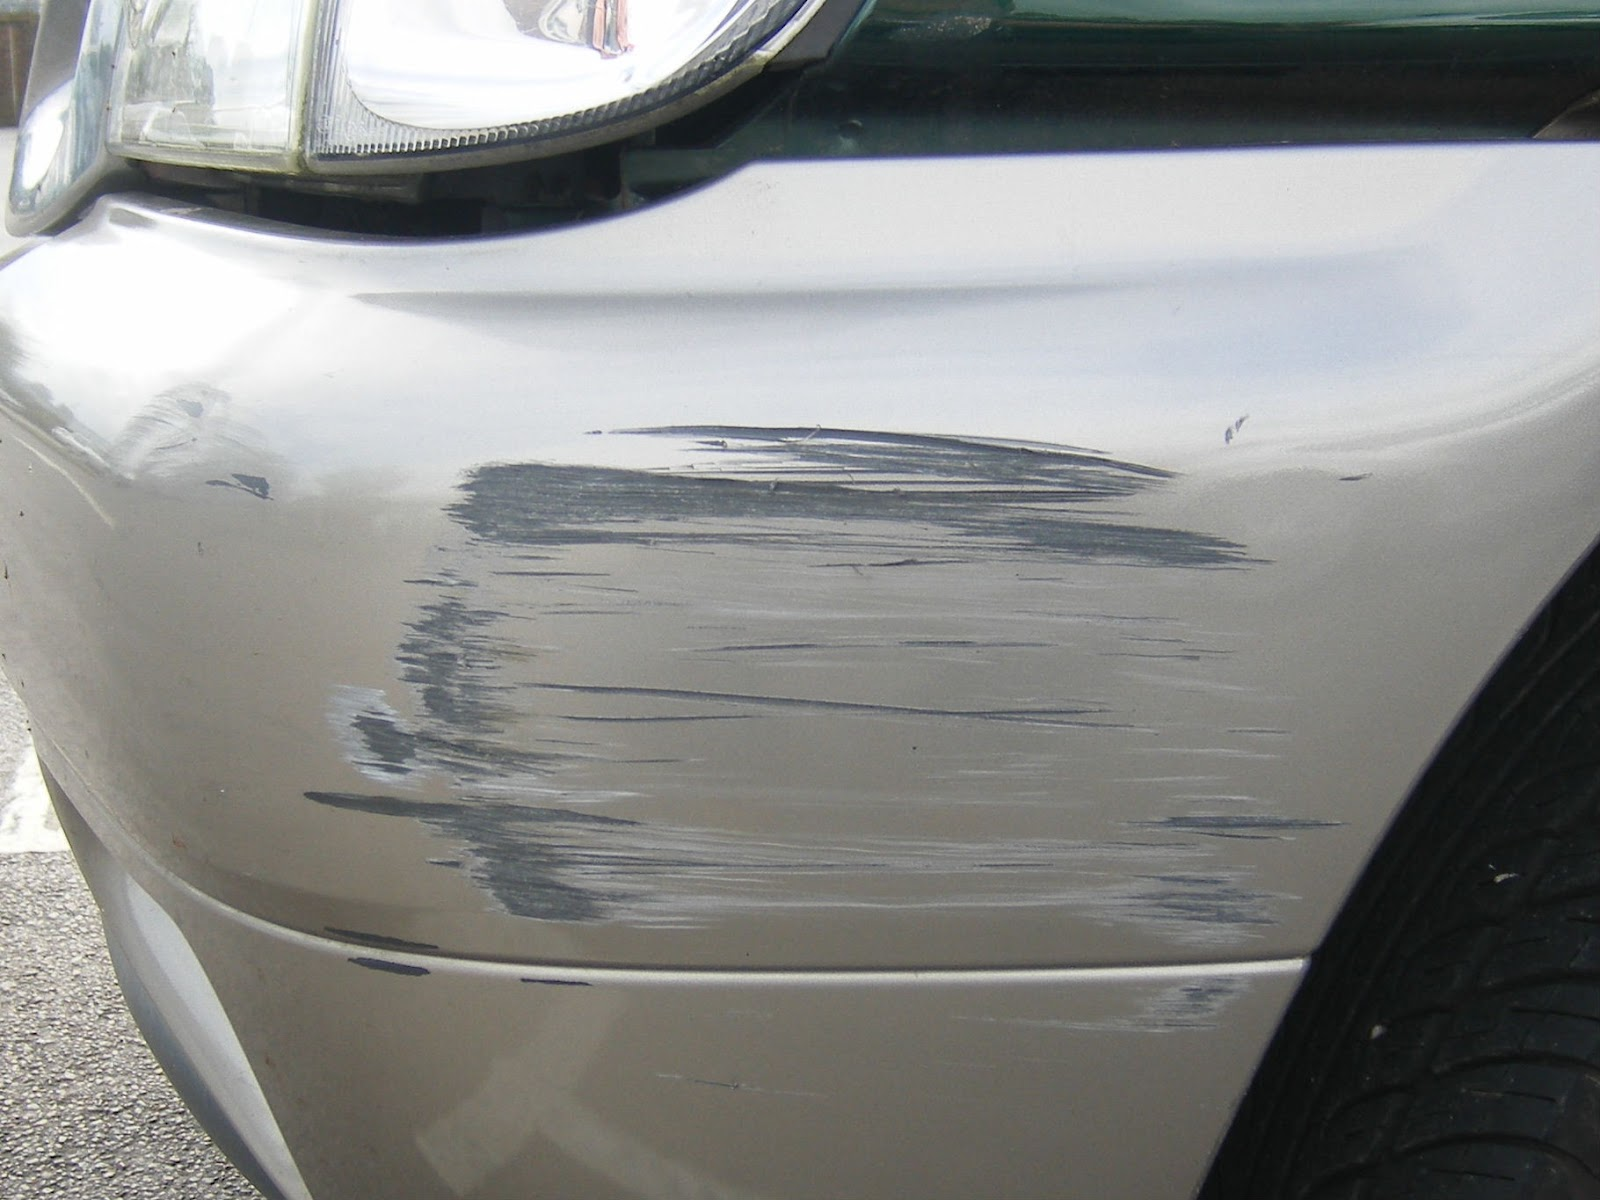

In [143]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

In [145]:
pipe2('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Validating that damage exists....
[[0.35308364]]
Validation complete - proceed to location and severity determination


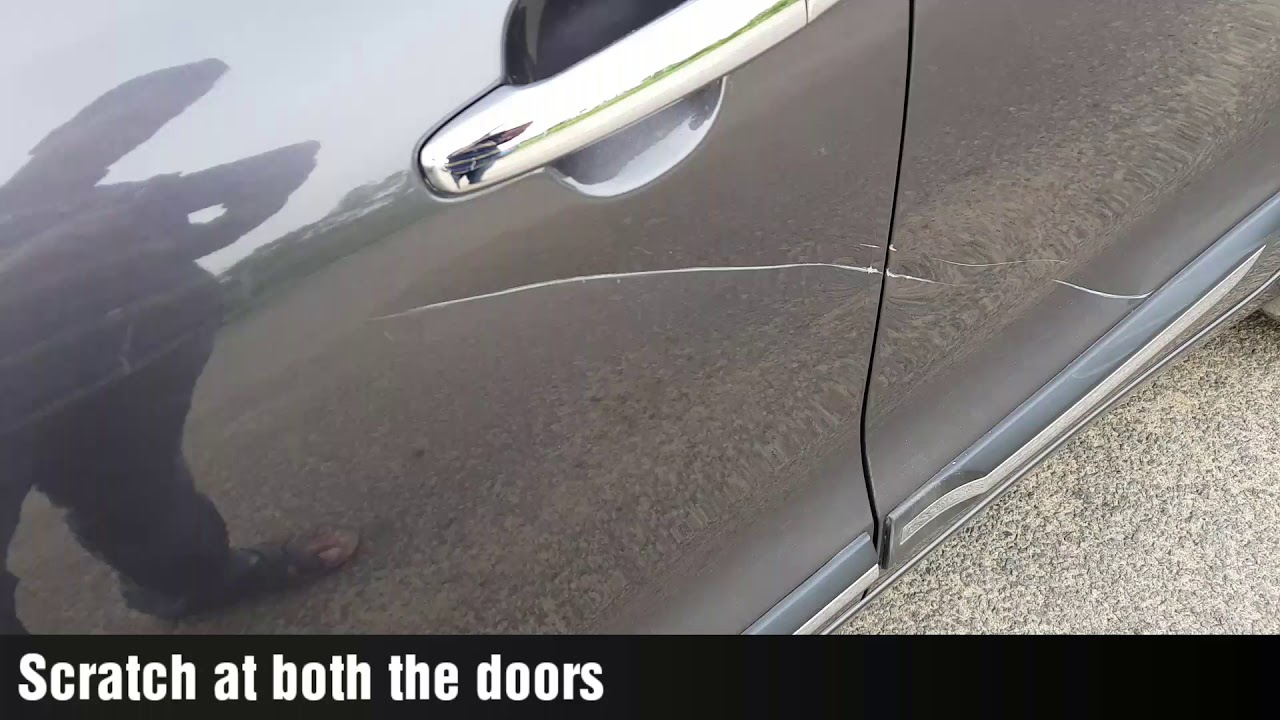

In [146]:
Image('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg')

In [147]:
pipe2('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Validating that damage exists....
[[0.35308364]]
Validation complete - proceed to location and severity determination


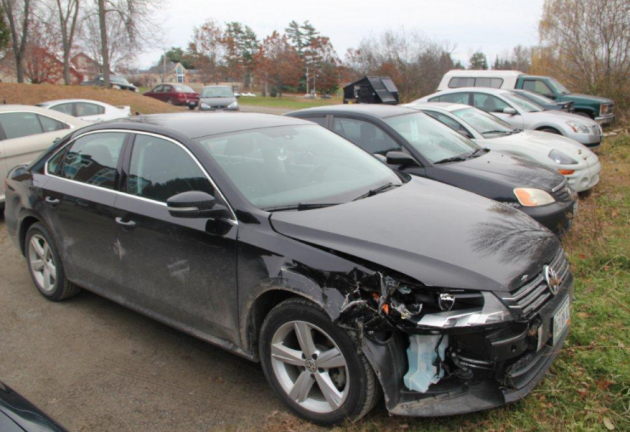

In [148]:
Image('http://blog.automart.co.za/wp-content/uploads/2014/09/Accident_Damaged_Car.png')

In [149]:
pipe2('http://blog.automart.co.za/wp-content/uploads/2014/09/Accident_Damaged_Car.png', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Validating that damage exists....
[[0.35308364]]
Validation complete - proceed to location and severity determination
